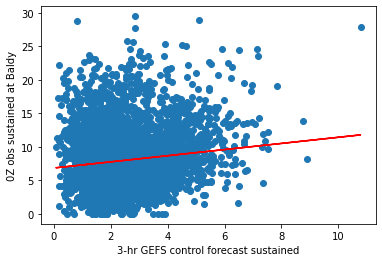

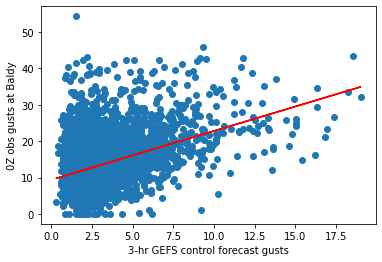

In [113]:
%matplotlib inline
import sys, os
import glob
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Read in the GEFS reanlysis, add descriptive column headers
df = pd.read_csv('gefsReanalysis.csv')
columnNames = ["Date"]
for i in range(1,17):
    columnNames.append('fhr'+str(i*3))
    columnNames.append('u'+str(i*3))
    columnNames.append('v'+str(i*3))
    columnNames.append('gust'+str(i*3))  
df.columns = columnNames

# Create datetime objects for the first and last days in the reanlysis data. 
# Will need this because it covers a shorter timespan than the obs
firstDate = df['Date'][1]
lastDate = df['Date'][len(df)-1]
firstDate = datetime.strptime(str(firstDate), '%Y%m%d%H')
lastDate = datetime.strptime(str(lastDate), '%Y%m%d%H')

# Setup empty placeholders for observed winds
df["ObsWind"] = np.nan
df["ObsDir"] = np.nan
df["ObsGust"] = np.nan

# Read in observed winds at Alta
df2 = pd.read_csv('AMB_wind_19970101_20201119.csv')

# Iterate through the observations. This is slow, but it's the only way I know of to merge the forecasts and obs
for index, row in df2.iterrows():
    # Create a datetime object for the observation date, format it the same way as the GEFS reanlysis data
    dateString = row['date_time'].strip('Z').replace('-',':')
    date = datetime.strptime(dateString, '%Y:%m:%dT%H:%M:%S')
    
    # If the date is within our reanalysis, and we're at hour 0, use it
    if lastDate >= date >= firstDate:
        if date.hour == 0:
            
            # Format the date the same as the reanlysis data
            formattedDate = datetime.strftime(date, '%Y%m%d%H')
            
            # Find the matching row in the reanlysis dataframe
            i = df.Date[df.Date == int(formattedDate)].index.tolist()
            
            # Add the observed values to the appropriate row
            # Filter to remove missing data (-999) and remove spuriously high readings
            if 60 > row['wind_speed_m/s'] >= 0:
                df.at[i,"ObsWind"] = row['wind_speed_m/s']
            if row['wind_direction_degrees'] >= 0:   
                df.at[i,"ObsDir"] = row['wind_direction_degrees']
            if 75 > row['wind_gust_m/s'] >= 0:
                df.at[i,"ObsGust"] = row['wind_gust_m/s']

# Now that we have everything in one dataframe, we can trim any rows with missing values                
df = df.dropna()
#print(df)

# Simple linear regression tests for wind speed and gust
U = df.iloc[:, 2].values
V = df.iloc[:, 3].values
mag = (U**2 + V**2)**0.5
X = mag.reshape(-1, 1)  
Y = df.iloc[:, 65].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("3-hr GEFS control forecast sustained")
plt.ylabel("0Z obs sustained at Baldy")
plt.show()

X = df.iloc[:, 4].values.reshape(-1, 1)  
Y = df.iloc[:, 67].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("3-hr GEFS control forecast gusts")
plt.ylabel("0Z obs gusts at Baldy")
plt.show()
